# Course assessment: project part 1 (M. Garcin)

## Numerical processing of financial data

#### Objective
The goal of this project is to assess the existence of serial information in a time series of prices and in a time series of volatilities.

- Please write commented code. You can also use text cells for your comments and explanations.
- The code must follow the good coding principles (it must be clean, readable, etc.).
- Graphs must have a title, a legend and their axes must be labeled.
- At the end, submit your notebooks __and a pdf file of 5 to 8 pages__ into the Moodle Assignment you will find in the section "Assessment: projects".
This separate pdf file is intended to be a (very) short paper : a standalone document that summarizes the work you have carried out in the notebooks and the results you have obtained (being they positive or negative), with figures. It has to be self-contained in the sense that one has to be able to read your report and understand its content without having to look into your notebooks, which will be checked afterwards.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Dataset

You will use the dataset (Excel files) of one-minute observations (OHLC prices) provided in Moodle for TP1 (Session 1). The dataset consists in the 40 constituents of the French stock index CAC 40 (as of 2022/2023). The biggest capitalizations are: LVMH (MC), L'Oréal (OR), TotalEnergies (TTE), Sanofi (SAN), Hermès (RMS), Airbus (AIR)... You have to choose one of these stocks and work with it for all the project.

The time range is September 2022-March 2023. Pay attention to the fact that some stocks don't have a price every minute (less liquid, like SW): avoid them.



In [20]:
data_AIR = pd.read_excel('AIR_prices.xlsx', engine='openpyxl', header=1)
data_AIR.head()

,Dates,Open,Close,High,Low
0,2022-09-13 09:00:00,100.24,100.28,100.38,100.14
1,2022-09-13 09:01:00,100.26,100.26,100.36,100.22
2,2022-09-13 09:02:00,100.24,100.24,100.26,100.22
3,2022-09-13 09:03:00,100.22,100.26,100.28,100.12
4,2022-09-13 09:04:00,100.22,100.26,100.26,100.20


Let's prepare the dataset for the incoming analysis - splitting the date and computing the return

In [21]:
data_AIR['Date only'] = data_AIR['Dates'].dt.date
data_AIR['Hour_Minute'] = data_AIR['Dates'].dt.strftime('%H:%M')
data_AIR['Return'] = data_AIR['Close'].pct_change()
data_AIR.head()

,Dates,Open,Close,High,Low,Date only,Hour_Minute,Return
0,2022-09-13 09:00:00,100.24,100.28,100.38,100.14,2022-09-13,09:00,NaN
1,2022-09-13 09:01:00,100.26,100.26,100.36,100.22,2022-09-13,09:01,-0.000199
2,2022-09-13 09:02:00,100.24,100.24,100.26,100.22,2022-09-13,09:02,-0.000199
3,2022-09-13 09:03:00,100.22,100.26,100.28,100.12,2022-09-13,09:03,0.000200
4,2022-09-13 09:04:00,100.22,100.26,100.26,100.20,2022-09-13,09:04,0.000000


Let's determine how many minutes do we have in a trading day.

In [22]:
# Group by 'Date only' and get the first and last minute for each date
first_last_minutes = data_AIR.groupby('Date only').agg({'Hour_Minute': ['first', 'last']})

# Flatten the MultiIndex columns
first_last_minutes.columns = ['First_Minute', 'Last_Minute']

first_last_minutes.head()

,First_Minute,Last_Minute
Date only,,
2022-09-13,09:00,17:35
2022-09-14,09:00,17:37
2022-09-15,09:00,17:35
2022-09-16,09:00,17:39
2022-09-19,09:00,17:37


We can consider that the last minute of the trading day is 17:35.

In [23]:
# Calculate the number of minute per day
minutes_per_day = 60 * 8 + 35
print(f'1 trading day has {minutes_per_day} minutes')

1 trading day has 515 minutes


# Parkinson volatility (Part 1)

We are interested in the two estimators
$$\widehat{D_{1,n}}=\frac{1}{n\sqrt{\tau}}\sum_{i=1}^n d_{(i-1)\tau,i\tau}\sqrt{\frac{\pi}{8}}$$
and
$$\widehat{D_{2,n}}=\left(\frac{1}{n\sqrt{\tau}}\sum_{i=1}^n d^2_{(i-1)\tau,i\tau}\frac{1}{4\ln(2)}\right)^{1/2},$$
where $d_{(i-1)\tau,i\tau}$ is the log high-low range (if necessary, see the first part of the course, from page 12).

* **1.a/** Write a function calculating the Parkinson annualized volatility $\widehat{D_{1,n}}$ of your asset using high-low ranges at a 1-minute interval.

* **1.b/** Do the same for the estimator $\widehat{D_{2,n}}$.

* **1.c/** Plot the two time series of Parkinson volatilities.



1.a/ Write a function calculating the Parkinson annualized volatility $\widehat{D_{1,n}}$ of your asset using high-low ranges at a 1-minute interval.

Let's create a log high-low range column at the 1-minute interval

In [24]:
data_AIR['lg_HL_range'] = np.log(data_AIR['High'] / data_AIR['Low'])
data_AIR.head()

,Dates,Open,Close,High,Low,Date only,Hour_Minute,Return,lg_HL_range
0,2022-09-13 09:00:00,100.24,100.28,100.38,100.14,2022-09-13,09:00,NaN,0.002394
1,2022-09-13 09:01:00,100.26,100.26,100.36,100.22,2022-09-13,09:01,-0.000199,0.001396
2,2022-09-13 09:02:00,100.24,100.24,100.26,100.22,2022-09-13,09:02,-0.000199,0.000399
3,2022-09-13 09:03:00,100.22,100.26,100.28,100.12,2022-09-13,09:03,0.000200,0.001597
4,2022-09-13 09:04:00,100.22,100.26,100.26,100.20,2022-09-13,09:04,0.000000,0.000599


Now, let's define our D1 daily Parkinson volatility function

In [ ]:
def calculate_D1(df, interval_per_day, interval_per_year=252):
    """
    Parameters:
    - df: DataFrame containing the 'lg_HL_range' and 'Date only' columns.
    - interval_per_year: Number of trading days per year, to annualize the volatility.
    - interval_per_day: Number of intervals per day, for example, for 1-minute time intervals: 515.
    Returns:
    - A series with the annualized Parkinson volatility for each day, using high low ranges at 1-minute intervals.
    """

    grouped = df.groupby('Date only')['lg_HL_range'] # Group by date for plotting

    # Using the given formula :
    D1 = grouped.apply(
        lambda x: (1 / len(x) ) *
                  x.sum() * np.sqrt(np.pi / 8) * 
                  np.sqrt(interval_per_year) *  np.sqrt(interval_per_day) # annualization
    )

    return D1

In [126]:
D1_parkinson_vol = calculate_D1(data_AIR, minutes_per_day, 252)

print(np.mean(D1_parkinson_vol))

0.14101976077850295


1.b/ Do the same for the estimator $\widehat{D_{2,n}}$.

In [ ]:
def calculate_D2(df, interval_per_day, interval_per_year=252):
    """
    Calculate the annualized Parkinson volatility estimator D2 as a time series over the days in the dataset.

    Parameters:
    - df: DataFrame containing the 'lg_HL_range' and 'Date only' columns.
    - interval_per_year: Number of intervals per year.

    Returns:
    - A Series with the annualized Parkinson volatility estimator D2 for each day.
    """
    grouped = df.groupby('Date only')['lg_HL_range'] # Group by date for plotting
    tau = 1 / (interval_per_day*interval_per_year)
    # Using the given formula :
    
    D2 = grouped.apply(
        lambda x: np.sqrt( 
            (1 / ( len(x))) *
            (x ** 2).sum() / (4 * np.log(2))
    ) * np.sqrt(1/tau) )# annualisation
    
    
    return D2

In [128]:
D2_parkinson_vol = calculate_D2(data_AIR, minutes_per_day)

print(np.mean(D2_parkinson_vol))

0.1778373563600774


1.c/ Plot the two time series of Parkinson volatilities.

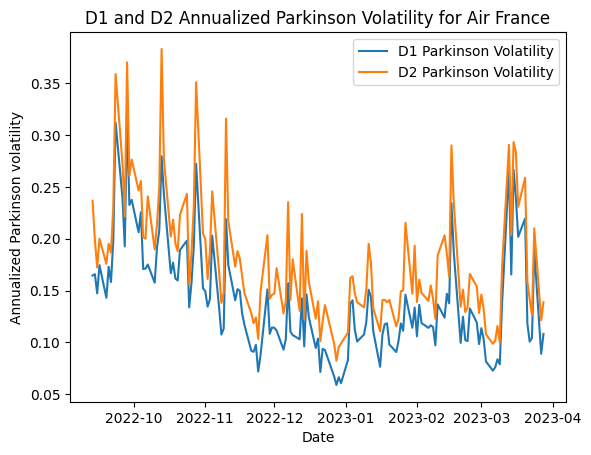

In [129]:
plt.plot(D1_parkinson_vol, label='D1 Parkinson Volatility')
plt.plot(D2_parkinson_vol, label='D2 Parkinson Volatility')
plt.title('D1 and D2 Annualized Parkinson Volatility for Air France')
plt.xlabel('Date')
plt.ylabel('Annualized Parkinson volatility')
plt.legend()

C:\Users\diane\AppData\Local\Temp\ipykernel_89760\901869297.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["Time Frame"] = df["Dates"].dt.floor(time_frame)  # Regrouper par heure ou demi-heure


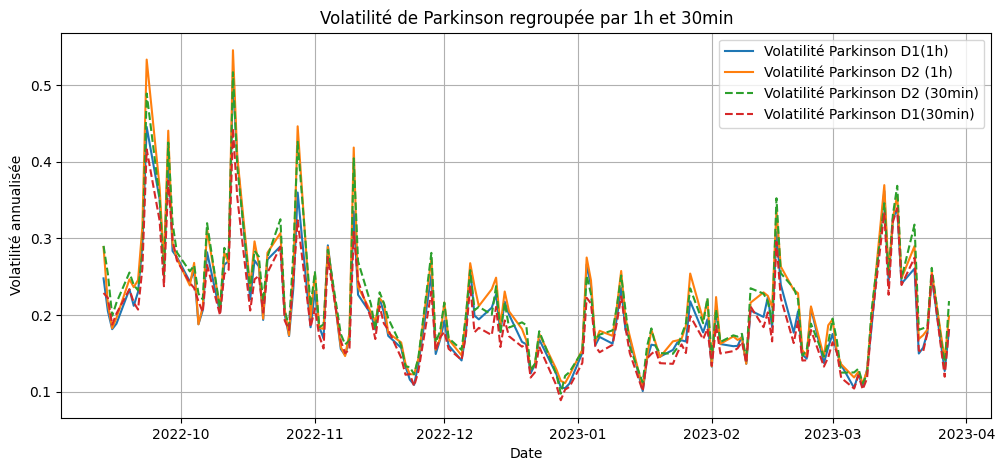

In [ ]:
def calculate_parkinson_volatility(df, time_frame, interval_per_day):
    df["Time Frame"] = df["Dates"].dt.floor(time_frame)  # Regrouper par heure ou demi-heure
    
    data_grouped = df.groupby(["Date only", "Time Frame"]).agg({"High": "max", "Low": "min"}).reset_index()
    
    data_grouped["lg_HL_range"] = np.log(data_grouped["High"] / data_grouped["Low"])
    
    grouped = data_grouped.groupby("Date only")["lg_HL_range"]
    
    D1 = calculate_D1(data_grouped, interval_per_day)
    D2 = calculate_D2(data_grouped, interval_per_day)

    return D1, D2

D1_parkinson_vol_hourly, D2_parkinson_vol_hourly = calculate_parkinson_volatility(data_AIR, 'H', 8.58)
D1_parkinson_vol_half_hour, D2_parkinson_vol_half_hourly = calculate_parkinson_volatility(data_AIR, '30min', 17.18)

plt.figure(figsize=(12,5))
plt.plot(D1_parkinson_vol_hourly, label='Volatilité Parkinson D1(1h)')
plt.plot(D2_parkinson_vol_hourly, label='Volatilité Parkinson D2 (1h)')
plt.plot(D2_parkinson_vol_half_hourly, label='Volatilité Parkinson D2 (30min)', linestyle='dashed')
plt.plot(D1_parkinson_vol_half_hour, label='Volatilité Parkinson D1(30min)', linestyle='dashed')
plt.title('Volatilité de Parkinson regroupée par 1h et 30min')
plt.xlabel('Date')
plt.ylabel('Volatilité annualisée')
plt.legend()
plt.grid(True)
plt.show()

# Serial information (Part 2)

We are interested in the serial information of two financial daily time series: price returns and volatilities.

In order to get the serial information (if necessary, read again the first part of the course, from page 22), we need several functions.

First, we need Gray's binary code.
Indeed, for a given length $L<n$, $2^L$ binary sequences (of 0s and 1s) are possible. Gray's binary code makes it possible to order them (Gray's code is the index $i$ in the following vectors $G^L_i$). If $L=3$, the 8 sequences are $(G^3_1,...,G^3_8)=((0,0,0),(0,0,1),(0,1,1),(0,1,0),(1,1,0),(1,0,0),(1,0,1),(1,1,1))$.

We provide below the function returning Gray's binary code.

In [135]:
def binary_Gray_code(binary_array):
    # binary_array contains a binarized sequence of returns
    res = 0
    for val in binary_array:
        res = 2 * res + val
    return res

2.a/ Write a function returning the empirical estimator of the probability $p_i^L$ of sub-series of length $L$:
$$p^L_i=\mathbb P((X_{.},X_{.+1},...,X_{.+L-1})=G^L_i).$$
The arguments of this function are:
  * time_series, an array containing all the binarized 1-minute price returns (so it is a sequence containing 0s and 1s),
  * $L$, the length of the sub-series to be considered; these sub-series are all the sub-series of consecutive observations in the array time_series.

In [136]:
def empirical_probability_subseries(time_series, L):
    """
    Calculate the empirical probability of each sub-series of length L in a binarized time series.

    Parameters:
    - time_series: An array containing all the binarized 1-minute price returns (0s and 1s).
    - L: The length of the sub-series to be considered.

    Returns:
    - A dictionary with Gray code indices as keys and their empirical probabilities as values.
    """

    # Check if the length of the time series is less than L
    if len(time_series) < L:
        print(f"Warning: The length of the time series ({len(time_series)}) is less than L ({L}). Cannot compute probabilities.")
        return {}
    
    # Initialize a dictionary to store the count of each sub-series
    subseries_count = {}

    # Iterate over the time series to extract sub-series of length L
    for i in range(len(time_series) - L + 1):
        sub_series = time_series[i:i + L]
        gray_code = binary_Gray_code(sub_series)

        if gray_code in subseries_count:
            subseries_count[gray_code] += 1
        else:
            subseries_count[gray_code] = 1

    # Calculate the total number of sub-series
    total_subseries = len(time_series) - L + 1

    # Calculate the empirical probability for each sub-series
    empirical_probabilities = {k: v / total_subseries for k, v in subseries_count.items()}

    return empirical_probabilities

2.b/ Write a function returning the entropy $H^L$:
$$H^L=-\sum_{i=1}^{2^L} p^L_i\log_2\left(p^L_i\right).$$

In [137]:
def calculate_entropy(empirical_probabilities):
    """
    Calculate the entropy H^L given the empirical probabilities of sub-series of length L.

    Parameters:
    - empirical_probabilities: A dictionary with Gray code indices as keys and their empirical probabilities as values.

    Returns:
    - The entropy H^L.
    """
    entropy = 0.0

    for probability in empirical_probabilities.values():
        if probability > 0:  # Avoid log(0)
            entropy -= probability * np.log2(probability)

    return entropy

2.c/ Write a function returning the serial information $I^{L+1}=1+H^L-H^{L+1}$, for $L\in [\![1,L^{\max}]\!]$. The two arguments of this function are time_series and $L^{\max}$.

In [139]:
def calculate_serial_information(time_series, L_max):
    """
    Calculate the serial information I^{L+1} for L in the range [1, L_max].

    Parameters:
    - time_series: An array containing all the binarized 1-minute price returns (0s and 1s).
    - L_max: The maximum length of the sub-series to be considered.

    Returns:
    - A dictionary with keys as the values of L and values as the corresponding serial information I^{L+1}.
    """

    # Check if the length of the time series is sufficient for the given L_max
    if len(time_series) < L_max + 1:
        raise ValueError(f"The length of the time series ({len(time_series)}) is insufficient for L_max ({L_max}). "
                         f"The time series should have at least {L_max + 1} elements.")
    
    serial_information = {}

    for L in range(1, L_max + 1):
        # Calculate empirical probabilities for sub-series of length L and L+1
        empirical_probabilities_L = empirical_probability_subseries(time_series, L)
        empirical_probabilities_L_plus_1 = empirical_probability_subseries(time_series, L + 1)

        # Calculate entropies H^L and H^{L+1}
        H_L = calculate_entropy(empirical_probabilities_L)
        H_L_plus_1 = calculate_entropy(empirical_probabilities_L_plus_1)

        # Calculate serial information I^{L+1}
        serial_information[L] = 1 + H_L - H_L_plus_1

    return serial_information

2.d/ Write a function returning the asymptotic confidence bound for a zero serial information, using the Gamma distribution presented in the course: we recall that under the assumption of serial independence, $\widehat{I^{L+1}_n}$ follows a gamma distribution $\Gamma(k,\theta)$ of shape parameter $k=2^{L-1}$ and scale parameter $\theta=1/\ln\left(2\right)n$. The arguments of the function are:
  * $L$,
  * $n$,
  * a significance level $\alpha$, equal by default to 0.95.

In [140]:
def asymptotic_confidence_bound(L, n, alpha=0.95):
    """
    Calculate the asymptotic confidence bound for zero serial information using the Gamma distribution.

    Parameters:
    - L: The length of the sub-series.
    - n: The number of observations.
    - alpha: The significance level (default is 0.95).

    Returns:
    - The confidence bound for zero serial information.
    """
    # Shape parameter
    k = 2**(L - 1)

    # Scale parameter
    theta = 1 / (np.log(2) * n)

    # Calculate the quantile of the Gamma distribution
    confidence_bound = stats.gamma.ppf(alpha, a=k, scale=theta)

    return confidence_bound

2.e/ From your one-minute dataset of close prices of a stock, build a time series of daily price returns (between two consecutive ends of days). Apply the above functions to calculate the serial information of this time series. Plot this information as a function of $L$, with $L^{\text{max}}=6$. Is there any statistically significant serial information?

In [ ]:
# first we compute the daily returns
returns_daily = data_AIR.groupby("Date only")['Close'].last().pct_change().dropna()

# then we binarise daily proce returns
time_series_binary = (returns_daily > 0).astype(int).values

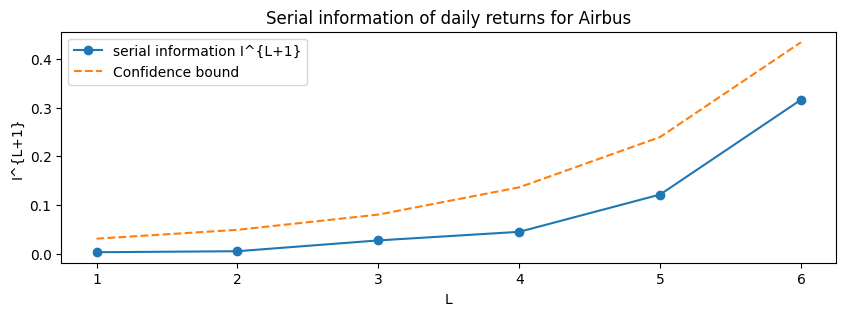

In [149]:
L_max = 6
serial_info = calculate_serial_information(time_series_binary, L_max)

# we compute the confidence bounds for the serial information
n = len(time_series_binary)
confidence_bounds = {L: asymptotic_confidence_bound(L, n) for L in range(1, L_max + 1)}

plt.figure(figsize=(10,3))
plt.plot(serial_info.keys(), serial_info.values(), marker='o', label='serial information I^{L+1}')
plt.plot(confidence_bounds.keys(), confidence_bounds.values(), linestyle='dashed', label='Confidence bound')
plt.xlabel('L')
plt.ylabel('I^{L+1}')
plt.title('Serial information of daily returns for Airbus')
plt.legend()
plt.show()

The serial information does not exceed the confidence limit, so there is no significant serial dependency. This result is surprising, because we would expect the returns not to be random but to follow a certain structure or pattern, something that we can use to predict it. 

2.f/ Calculate the serial information of the time series of daily log-variations of one of the two Parkinson volatilities. Plot this information as a function of $L$, with $L^{\text{max}}=6$. Is there any statistically significant serial information?


In [151]:
# We calculate the Parkinson volatility for each day
parkinson_volatility = data_AIR.groupby("Date only")["lg_HL_range"].sum()

# then the logarithmic changes in volatility
log_volatility_changes = np.log(parkinson_volatility).diff().dropna()

# and finally we binarize the time series of volatility changes
time_series_binary_volatility = (log_volatility_changes > 0).astype(int).values

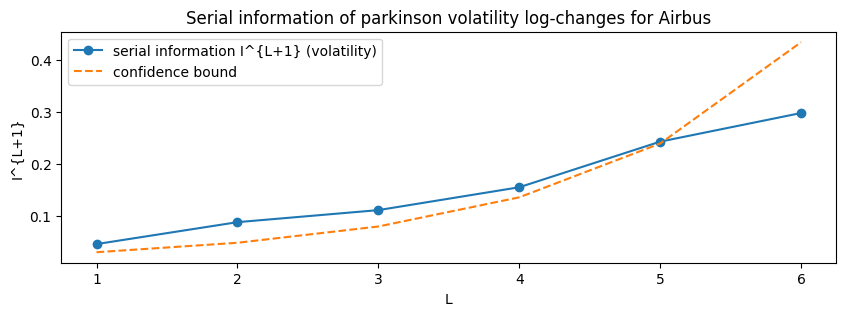

In [155]:
L_max = 6
serial_info_volatility = calculate_serial_information(time_series_binary_volatility, L_max)

n_volatility = len(time_series_binary_volatility)
confidence_bounds_volatility = {L: asymptotic_confidence_bound(L, n_volatility) for L in range(1, L_max + 1)}

plt.figure(figsize=(10,3))
plt.plot(serial_info_volatility.keys(), serial_info_volatility.values(), marker='o', label='serial information I^{L+1} (volatility)')
plt.plot(confidence_bounds_volatility.keys(), confidence_bounds_volatility.values(), linestyle='dashed', label='confidence bound')
plt.xlabel('L')
plt.ylabel('I^{L+1}')
plt.title('Serial information of parkinson volatility log-changes for Airbus')
plt.legend()
plt.show()

Here, for L<6, the serial information is above the confidence bound, which means that the time series of log-changes in volatility is not random. Then at L=6, so for a more complex structure, their is no more serial dependency. We could guess that the volatility has a "short-term memory". 

on devrait pas s'attendre à des fonctions décroissantes??